### 训练数据集目录结构(不带验证集)

plates -> 车牌号.jpg

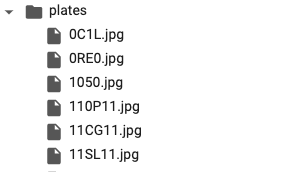

### 训练输出

* char_idx.json 结构 {'A': 1, 'B': 2, ...}
* idx_char.json 结构 ['A', 'B', ...]
* hk.h5


In [ ]:
!gdown --id '1wdtP__Oc_qXH0YCm-QygzXAa-W2UeMD0' --output plates.zip
!unzip -o plates.zip > /dev/null

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
glob = pathlib.Path('plates').glob("*")
plates = [str(p.name).replace('.jpg', '') for p in glob]
max_length = len(max(plates, key=lambda plate: len(plate)))

char_set = set()
for plate in plates:
  for c in plate:
    char_set.add(c)

char_idx = {}
idx_char = []
for idx, c in enumerate(char_set):
  char_idx[c] = idx
  idx_char.append(c)

# 最后一个占位字符
idx_char.append('')  

# 保存解释规则
with open('char_idx.json', 'w') as f:
  json.dump(char_idx, f)

with open('idx_char.json', 'w') as f:
  json.dump(idx_char, f)

char_type = len(char_idx)

label = [[] for i in range(max_length)]
for p in plates:
  for i in range(max_length):
    if i < len(p):
      label[i].append(char_idx[p[i]])
      continue
    label[i].append(char_type)

In [4]:
# build dataset
image_path_ds = tf.data.Dataset.from_tensor_slices(plates)
label_ds = [tf.data.Dataset.from_tensor_slices(l) for l in label]
batch_size = 128

def load_and_process_image(image_path, l0, l1, l2, l3, l4, l5, l6, l7):
    image = tf.io.read_file('plates/' + image_path + '.jpg')
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [80, 240])
    image /= 255.0
    return image, (l0, l1, l2, l3, l4, l5, l6, l7)


ds = (
    tf.data.Dataset.zip((image_path_ds, label_ds[0], label_ds[1], label_ds[2], label_ds[3], label_ds[4], label_ds[5], label_ds[6], label_ds[7]))
        .map(load_and_process_image)
        .cache()
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
# check dataset
for d in ds.take(1):
  images = d[0]
  plt.imshow(images[0])
  plt.show()
  l = d[1]
  plate = []
  for i in range(8):
    plate.append(idx_char[l[i][0]])
  print(plate)

In [ ]:
# define model
input_layer = tf.keras.layers.Input((80, 240, 3))
x = input_layer
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)
for i in range(3):
    x = tf.keras.layers.Conv2D(filters=32 * 2 ** i, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=32 * 2 ** i, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)

output_layer = [tf.keras.layers.Dense(len(idx_char), activation='softmax', name='c%d' % (i))(x) for i in range(8)]

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(ds, epochs=100)
model.save("hk.h5")

In [ ]:
# check
image = tf.io.read_file('plates/1W2013.jpg')
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [80, 240])
image /= 255.0

result = model.predict(np.array([image]))

plate = ''
for i in result:
  idx = np.argmax(i)
  plate += idx_char[idx]

plt.imshow(image)  
plt.show()
print('车牌号 {}'.format(plate))